In [45]:
from pandas.core.api import DataFrame
from prompt_toolkit.application import current
import pandas as pd
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
from tabulate import tabulate
import matplotlib.pyplot as plt

# REQUIRES: Dataframe has an even number of cols, and column of interest is at every even column
# EFFECT: Drops all odd columns in a dataframe
def drop_odd_cols(dataframe):
  df = dataframe
  col_drop_list = []
  for i,col in enumerate(df.columns): 
    if(i % 2 == 0):
      col_drop_list.append(col)
  df = df.drop(col_drop_list,axis = 1)
  return df


# REQUIRES: Folder path must be 1 directories above .xlsx files ({INPUT_PATH} -- > xlsx files)
# EFFECT: Reads all xlsx files and returns a 3D numpy array (batch_size, x,y) with data stacked along new axis (axis = 0)
def excel_reader(folder_path): 
    files = glob.glob(folder_path + "/*.xlsx")
    df_list = []
    for file in files:
        df = pd.read_excel(file)
        df = drop_odd_cols(df)
        df_list.append(df)
    np_array = np.array(list(map(lambda x: x.to_numpy(), df_list)))
    np_array = np_array.reshape((len(df_list), len(df.axes[0]), len(df.axes[1])))
    return np_array

# EFFECT: Returns list of non-hidden folders & files present in a directory 
def listdir_non_hidden(folder_path): 
    folders = []
    for folder in os.listdir(folder_path):
        if not folder.startswith('.'):
            folders.append(folder)
    return folders

# REQUIRES: x,y,z be not empty
# EEFECT: generate model structure based on input shape of x,y,z
def create_model(datas, x,y,z):
  model = tf.keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x,y,z)),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.MaxPooling2D((2, 2)),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(len(datas)*4, activation = 'relu'),
      layers.Dense(len(datas)),
      layers.Softmax()]) # UNCERTAINTY: is softmax allowed here?

  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
      
  return model

# REQUIRES: Model weights in folder must match current model architecture
# EFFECT: Load a model from its saved weights
def load_model(path, x,y,z):
  model = create_model(x,y,z)
  model.load_weights(path)
  return model

# REQUIRES: - Maximum and minimum values are more than and less than 0 respectively 
#           - Folder path must be 2 directories above .xlsx files ({INPUT_PATH} -- > categories -- > xlsx files)
# EFFECT: Summarizes data of xslx files in a folder by returning four items: 
#         1. maximum value, 2. minimum value, 3. regular array whose elements are numpy datas corresponding to categories (e.g. [np1,np2,np3] ), 4. folder categories
def summarize(path):
  folders = listdir_non_hidden(path)
  max_val = 0
  min_val = 0
  datas = []
  for folder in folders:
    data = excel_reader(path + folder)
    current_max = data.max()
    current_min = data.min()
    if(max_val < current_max):
      max_val = current_max
    if(min_val > current_min):
      min_val = current_min
    datas.append(data)
  return datas, max_val, min_val, folders

# REQUIRES: Index >= 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model & are accurate in name
# EFFECT: Prints top 3 predictions for a given data with their respective probabilities
def predict_top_three(index, predictions, choices):
  prediction = []
  for i in range(len(predictions[index])):
    prediction.append(predictions[index][i])
  prediction = np.asarray(prediction)
  ranks = []
  for i in range(3):
    current_index = np.argmax(prediction)
    ranks.append(current_index)
    prediction[current_index] = 0
  print("The top three predictions are:")
  print("1.", choices[ranks[0]], "with probability of", predictions[index][ranks[0]])
  print("2.", choices[ranks[1]], "with probability of", predictions[index][ranks[1]])
  print("3.", choices[ranks[2]], "with probability of", predictions[index][ranks[2]])
  print()
  return

# REQUIRES: start_index, num_terms > 0, predictions is a 2D array and >= 3 along axis = 0, and choices reflect number of output nodes for model
# EFFECT: Prints top prediction for a given range (start-end)
def predict_top_three_multiple(start_index,num_terms, predictions,choices):
  range_predictions = predictions[start_index:start_index + num_terms]
  for i in range(num_terms):
    print("Data(", i, ")")
    predict_top_three(i,range_predictions,choices)
  return

# REQUIRES: Index >= 0, data is a 4D array, predictions is a 2D array, choices reflect number of nodes of output, category is 1D array containing names of experimental categories
# EFFECT: Display a summary of a specific experimental data using a bar graph
def display_predictions(index, data, predictions, choices, category, category_index): 
    fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 3]}, figsize=(25,10))
    # first subplot
    ax[0].imshow(data[index,:,:,0], aspect = 'auto', cmap = 'seismic')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(f"Data({index}) from category: {category[category_index[index]]}", size = 20)
    # second subplot 
    thisplot = ax[1].bar(range(len(category)), predictions[index], color="#FFCCCB")
    ax[1].set_xticks(range(len(category)))
    ax[1].set_yticks([])
    ax[1].set_ylim([0,1])
    predicted_label = np.argmax(predictions[index])
    thisplot[predicted_label].set_color('#90EE90')
    ax[1].set_title(f"Predicted Category: {category[predicted_label]} ({predicted_label} on graph)", size = 20)
    # to label each bar with percentage on top   
    for i, p in enumerate(predictions[index]):
        ax[1].text(i - 0.05, p + 0.01, str(round(p*100,2)) + '%', color='blue', size = 8)

drive.mount('/content/drive/')
%cd "/content/drive/My Drive/Maldonado Lab/"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Maldonado Lab


In [32]:
# relative path to training data 
trn_data_path =  "matrix-data/"
# relative path to experimental data
exp_data_path =  "matrix-data/"

# gather training datas & make labels
trn_datas, max_trn_val, min_trn_val, trn_categories = summarize(trn_data_path)
train_data = np.vstack(trn_datas)
train_labels = []
for i in range(len(trn_datas)):
    for j in range(len(trn_datas[i])):
        train_labels.append(i)
train_labels = np.asarray(train_labels)

# gather experimental data & make categories
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path)
experimental_data = np.vstack(exp_datas)
exp_categories_index = []
for i in range(len(exp_datas)):
  for j in range(len(exp_datas[i])):
    exp_categories_index.append(i)
exp_categories_index = np.asarray(exp_categories_index)

# normalize data (shift range from negative-positive values to 0-1 values)
max_val = max(max_trn_val,max_exp_val)
min_val = min(min_trn_val,min_exp_val)
train_data = (train_data - min_val) / (max_val - min_val)
experimental_data = (experimental_data - min_val) / (max_val - min_val)
# write max and min value to txt file for future data checking/normalization
os.remove('max-min.txt')
np.savetxt('max-min.txt',[max_val,min_val])

# add dimensionality along last axis (3D --> 4D) since CNN requires 4D input
train_data = np.expand_dims(train_data, axis = len(train_data.shape))
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))

print("Dimensions of training data:",train_data.shape)
print("Dimensions of experimental data:",experimental_data.shape)


Dimensions of training data: (15, 426, 14, 1)
Dimensions of experimental data: (15, 426, 14, 1)


In [46]:
# make instance of model
x,y,z = train_data.shape[1], train_data.shape[2], train_data.shape[3]
model = create_model(trn_datas,x,y,z)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 424, 12, 32)       320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 212, 6, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 210, 4, 64)        18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 105, 2, 64)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 13440)             0         
                                                                 
 dense_18 (Dense)            (None, 100)              

In [47]:
# train model with 30-70 validation split
model.fit(train_data, train_labels, epochs = 50, validation_split = 0.3)

Epoch 1/50
1/1 [==============================] - 1s 828ms/step - loss: 1.0936 - accuracy: 0.5000 - val_loss: 1.2428 - val_accuracy: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 108ms/step - loss: 1.0335 - accuracy: 0.6000 - val_loss: 1.3740 - val_accuracy: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 96ms/step - loss: 0.9839 - accuracy: 0.5000 - val_loss: 1.4398 - val_accuracy: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 100ms/step - loss: 0.9619 - accuracy: 0.5000 - val_loss: 1.4560 - val_accuracy: 0.0000e+00
Epoch 5/50
1/1 [==============================] - 0s 103ms/step - loss: 0.9546 - accuracy: 0.5000 - val_loss: 1.4578 - val_accuracy: 0.0000e+00
Epoch 6/50
1/1 [==============================] - 0s 104ms/step - loss: 0.9499 - accuracy: 1.0000 - val_loss: 1.4580 - val_accuracy: 0.0000e+00
Epoch 7/50
1/1 [==============================] - 0s 120ms/step - loss: 0.9457 - accuracy: 0.5000 - val_loss: 1.4588 - val_accuracy: 0.00

In [ ]:
# if validation is good (>90%) --> save weights in path below
save_to_path = 
model.save_weights(save_to_path)

In [ ]:
# RUN THIS IF: model was previously saved and would only like to predict results on new experimental data
trn_data_path = 
exp_data_path =  
saved_path_weights = 

# load experimental data & model
exp_datas, max_exp_val, min_exp_val, exp_categories = summarize(exp_data_path)
# PITFALL: - ensure max_exp_val and min_exp_val of new batch is less than saved max and min values
#          - else, predictions could be inaccurate
experimental_data = np.vstack(exp_datas)
experimental_data = np.expand_dims(experimental_data, axis = len(experimental_data.shape))
choices = listdir_non_hidden(trn_data_path)
x,y,z = experimental_data.shape[1], experimental_data.shape[2], experimental_data.shape[3]
model = load_model(saved_path_weights, x,y,z)

1/1 [==============================] - 0s 125ms/step


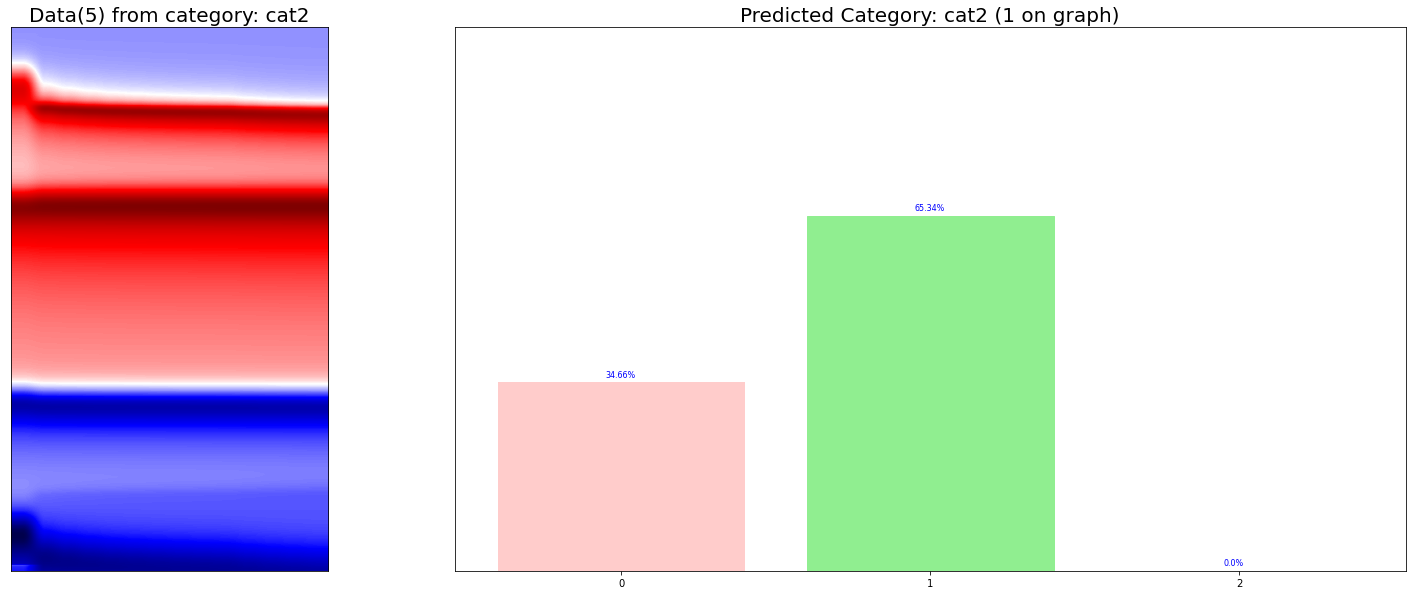

In [48]:
# TO DO: input i value of data you would like to see and j value of method of displaying
i = 5
j = 2
predictions = model.predict(experimental_data)

if(j == 0):
  predict_top_three(i,predictions,trn_categories)
elif(j == 1):
  predict_top_three_multiple(i,10,predictions,trn_categories)
elif(j == 2):
  display_predictions(i,experimental_data,predictions,trn_categories,exp_categories,exp_categories_index)